In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *
from qiskit import IBMQ

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [4]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 2
numQubit = 1
global iterations
global noisy

In [8]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [5]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 3
layers = 2

for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [9]:
def createEqSuperpos2BE():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(1)
    temp.h(0)
    return temp

In [60]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Section 6.D from https://arxiv.org/pdf/2105.12758
    The ciruit contains 5 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(4)
    
    superPosCircuit = createEqSuperpos2BE()
    circ.append(superPosCircuit, [0])

    circ.append(state, [1, 2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3])
    
    circ.cswap(0, 2, 3)
    
    circ.append(superPosCircuit.inverse(), [0])
    
    return circ

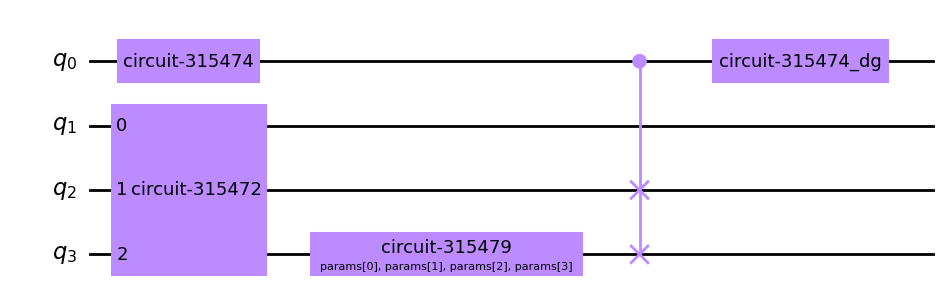

In [61]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [67]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [62]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [63]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [65]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [66]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [68]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [64]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the 1st qubit.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))

In [69]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[4.56951413 1.2996747  5.10383396 5.9228751 ]
Initial Cost :  0.5204570307490619


In [70]:
'''
True value calculated using the SDP.
'''
true_value = 1.0

In [71]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5204570307490619
Loss Value :  0.5769363417384028 1.0%
Loss Value :  0.8289938419800214 2.0%
Loss Value :  0.8320595561535991 3.0%
Loss Value :  0.8320836415879839 4.0%
Loss Value :  0.8346053145692279 5.0%
Loss Value :  0.8685896799044137 6.0%
Loss Value :  0.9849216631035994 7.0%
Loss Value :  0.9784100837467988 8.0%
Loss Value :  0.9814175335309989 9.0%
Loss Value :  0.9940518317520127 10.0%
Loss Value :  0.9993569605573253 11.0%
Loss Value :  0.999355925413289 12.0%
Loss Value :  0.9993545973866218 13.0%
Loss Value :  0.9995549451630888 14.0%
Loss Value :  0.9996672349731265 15.0%
Loss Value :  0.9999551311161673 16.0%
Loss Value :  0.9999799023286999 17.0%
Loss Value :  0.9999557685177851 18.0%
Loss Value :  0.999953748686927 19.0%
Loss Value :  0.9999370488846104 20.0%
Loss Value :  0.999923727589755 21.0%
Loss Value :  0.9999222422544594 22.0%
Loss Value :  0.9999673673057731 23.0%
Loss Value :  0.9999680444602186 24.0%
Loss Value :  0.9999987922192282 25.0%
Lo

In [72]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.5210613139877722
Loss Value :  0.5401316876744494 1.0%
Loss Value :  0.5542500709974706 2.0%
Loss Value :  0.8376212804970756 3.0%
Loss Value :  0.8819750754427893 4.0%
Loss Value :  0.9464501398862317 5.0%
Loss Value :  0.9505284504011189 6.0%
Loss Value :  0.9548625977345515 7.0%
Loss Value :  0.9585072401393435 8.0%
Loss Value :  0.9558506386482973 9.0%
Loss Value :  0.9365870734133576 10.0%
Loss Value :  0.9412387731727213 11.0%
Loss Value :  0.9630774391195895 12.0%
Loss Value :  0.9715327677438449 13.0%
Loss Value :  0.9656738120729002 14.0%
Loss Value :  0.9452908015076118 15.0%
Loss Value :  0.9644860668561717 16.0%
Loss Value :  0.9451827445554467 17.0%
Loss Value :  0.9391300569858494 18.0%
Loss Value :  0.9281907129548442 19.0%
Loss Value :  0.9332477726124102 20.0%
Loss Value :  0.9546237197402266 21.0%
Loss Value :  0.9642125276038331 22.0%
Loss Value :  0.9574267867186297 23.0%
Loss Value :  0.961303227681532 24.0%
Loss Value :  0.9580004047311115 25.0%


In [73]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9995263094711919


In [74]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.9999958107700686
Noisy :  0.9583956698651962
Noise Resilient Value :  0.9995263094711919


In [75]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("S2_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [76]:
writeToFile()